## Table of Contents

1. Stage 1 - Environment Setup and Aggregation Helpers  
2. Stage 2 - Data Loading, Relational Aggregation, and Merge  
3. Stage 3 - Modeling Base Construction and Split  
4. Stage 4 - Missingness Handling, Imputation, and Scaling  
5. Stage 5 - EDA, Processing Ledger, and Validation Checks  
6. Stage 6 - Feature Selection and SMOTE

---

### Stage 1 - Environment Setup

**What this cell does**  
Imports required libraries and sets the dataset root path.

**Inputs**  
Python environment with required packages.

**Outputs**  
Imported modules and `DATA_DIR` definition.

**Notes / assumptions**  
All downstream cells depend on these imports.

In [ ]:
# Core setup: imports and path foundation for all downstream cells.
from pathlib import Path
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path("home-credit-default-risk")

### Stage 1 - Data Loading Utility

**What this cell does**  
Defines a CSV loader utility that prints shapes for traceability.

**Inputs**  
Dataset filename and predefined `DATA_DIR`.

**Outputs**  
Loaded dataframe and shape logging.

**Notes / assumptions**  
CSV files are expected inside the dataset root directory.

In [3]:
def load_csv(filename):
    df = pd.read_csv(DATA_DIR / filename, low_memory=False)  # read from project data dir
    print(f"{filename}: {df.shape}")                         # traceability: show rows/cols
    return df                                                # return dataframe unchanged

### Stage 1 - Numeric Aggregation Helper

**What this cell does**  
Aggregates numeric columns by grouping key and adds grouped row counts.

**Inputs**  
A relational dataframe, grouping key, and table label.

**Outputs**  
Customer-level numeric aggregate features.

**Notes / assumptions**  
Grouping key and non-target ID-like columns are excluded from numeric aggregation.

In [4]:
def agg_numeric(df, group_var, df_name, agg_funcs=("mean", "max", "min", "sum")):
    df_name = str(df_name).upper()

    g = df.groupby(group_var)  # group to customer-level )
    counts = g.size().rename(f"{df_name}_ROW_COUNT").reset_index()  # row-count feature

    # numeric columns excluding group key and other SK_ID* columns
    num_cols = [
        c for c in df.select_dtypes(include=np.number).columns
        if c != group_var
    ]
    if len(num_cols) == 0:
        return counts  # only row-count available

    agg = g[num_cols].agg(agg_funcs)  # aggregate numeric signals per group
    agg.columns = [f"{df_name}_{col}_{stat}".upper() for col, stat in agg.columns]  # flatten MultiIndex
    agg = agg.reset_index()

    return agg.merge(counts, on=group_var, how="left") 


### Stage 1 - Categorical Aggregation Helper

**What this cell does**  
One-hot encodes categorical columns and aggregates counts and normalized counts by key.

**Inputs**  
A relational dataframe, grouping key, and table label.

**Outputs**  
Customer-level categorical aggregate features.

**Notes / assumptions**  
ID-like columns are excluded from one-hot encoding.

In [5]:
def count_categorical(df, group_var, df_name):
    df_name = str(df_name).upper()

    # categorical-like columns excluding key and other SK_ID* columns
    cat_cols = [
        c for c in df.select_dtypes(include=["object", "category", "bool"]).columns
        if c != group_var
    ]
    if len(cat_cols) == 0:
        return df[[group_var]].drop_duplicates().reset_index(drop=True)  # keep key only

    # one-hot + NA bucket; uint8 saves memory for wide dummy matrices
    dummies = pd.get_dummies(df[cat_cols], dummy_na=True).astype(np.uint8)
    dummies[group_var] = df[group_var].values  # attach group key for aggregation

    out = dummies.groupby(group_var).agg(["sum", "mean"])  # COUNT and COUNT_NORM
    out.columns = [
        f"{df_name}_{col}_{'COUNT' if stat == 'sum' else 'COUNT_NORM'}".upper()
        for col, stat in out.columns
    ]
    return out.reset_index()


### Stage 1 - Unified Aggregation Wrapper

**What this cell does**  
Combines numeric and categorical aggregation outputs for one table.

**Inputs**  
A relational dataframe, grouping key, and table label.

**Outputs**  
One-row-per-group aggregated dataframe.

**Notes / assumptions**  
Relies on the numeric and categorical helper functions defined earlier.

In [6]:
def agg_all(df, group_var, df_name):
    num = agg_numeric(df, group_var, df_name)          # numeric aggregates + row count
    cat = count_categorical(df, group_var, df_name)    # categorical COUNT / COUNT_NORM
    return num.merge(cat, on=group_var, how="left")    # unify per-table features


### Stage 2 - Build Application Base Table

**What this cell does**  
Loads train/test application tables, tags source split, and concatenates.

**Inputs**  
`application_train.csv`, `application_test.csv`.

**Outputs**  
Unified `app` table and row-count chart.

**Notes / assumptions**  
`TARGET` is set to null for test rows before concat.

application_train.csv: (307511, 122)
application_test.csv: (48744, 121)
app (train+test): (356255, 123)


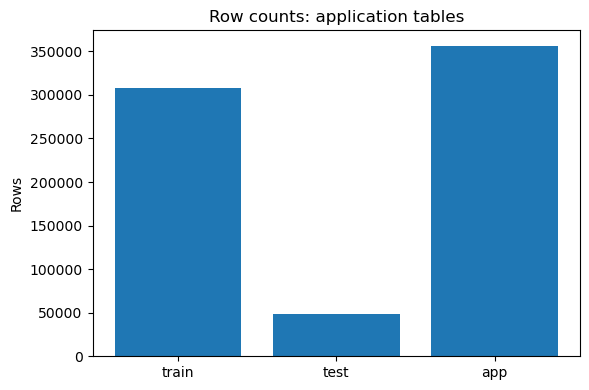

In [7]:
train = load_csv("application_train.csv")
test  = load_csv("application_test.csv")

train["_is_train"] = 1                 # flag original train rows
test["_is_train"]  = 0                 # flag original test rows
test["TARGET"]     = np.nan            # align schema for concat

app = pd.concat([train, test], ignore_index=True, sort=False)  # unified application table
print("app (train+test):", app.shape)

# simple diagnostic: row counts
plt.figure(figsize=(6, 4))
plt.bar(["train", "test", "app"], [train.shape[0], test.shape[0], app.shape[0]])
plt.title("Row counts: application tables")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()


### Stage 2 - Bureau + Bureau Balance Aggregation

**What this cell does**  
Performs two-step aggregation from `bureau_balance` to `bureau`, then to customer level.

**Inputs**  
`bureau.csv`, `bureau_balance.csv`.

**Outputs**  
`bureau_agg_all` and feature-expansion diagnostics.

**Notes / assumptions**  
Intermediate wide tables are deleted to control memory.

In [8]:
bureau = load_csv("bureau.csv")
bb = load_csv("bureau_balance.csv")

bureau_cols_before = bureau.shape[1]  # raw bureau column count

# 1) bureau_balance -> SK_ID_BUREAU aggregation, then merge into bureau
bb_agg = agg_all(bb, group_var="SK_ID_BUREAU", df_name="bureau_balance")  # one row per SK_ID_BUREAU
bureau = bureau.merge(bb_agg, on="SK_ID_BUREAU", how="left")              # enrich bureau with bb signals
bureau_cols_after_bb = bureau.shape[1]                                   # expanded column count

# free large intermediates early (helps memory)
del bb, bb_agg
gc.collect()


bureau.csv: (1716428, 17)
bureau_balance.csv: (27299925, 3)


3041

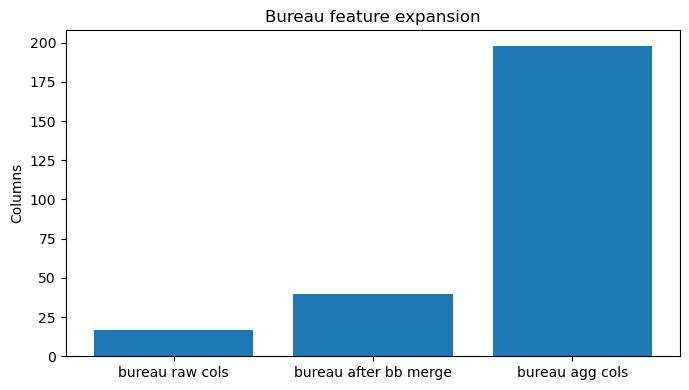

3215

In [9]:
# 2) bureau (enriched) -> SK_ID_CURR aggregation (customer-level)
bureau_agg_all = agg_all(bureau, group_var="SK_ID_CURR", df_name="bureau")  # one row per SK_ID_CURR

# diagnostic: how many columns were added / kept
plt.figure(figsize=(7, 4))
plt.bar(
    ["bureau raw cols", "bureau after bb merge", "bureau agg cols"],
    [bureau_cols_before, bureau_cols_after_bb, bureau_agg_all.shape[1]]
)
plt.title("Bureau feature expansion")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

del bureau
gc.collect()

### Stage 2 - Aggregate Remaining Relational Tables

**What this cell does**  
Aggregates previous, POS cash, credit card, and installment tables to customer level.

**Inputs**  
Raw relational tables keyed by `SK_ID_CURR`.

**Outputs**  
Per-table aggregated matrices and column-count diagnostics.

**Notes / assumptions**  
Each table is processed independently with shared aggregation logic.

previous_application.csv: (1670214, 37)
POS_CASH_balance.csv: (10001358, 8)
credit_card_balance.csv: (3840312, 23)
installments_payments.csv: (13605401, 8)


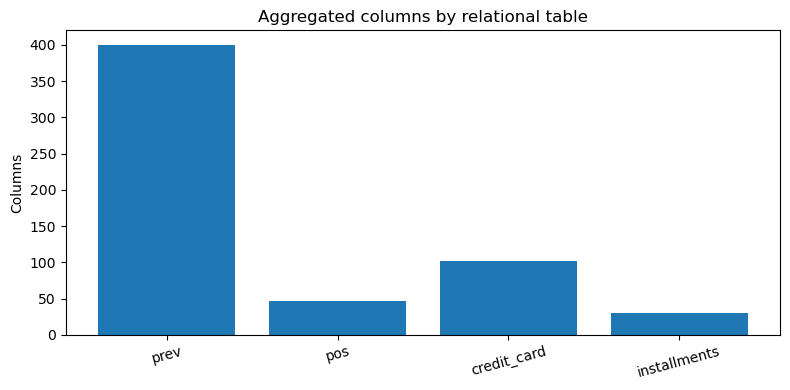

In [10]:
# Reasoning: Aggregate all remaining relational tables to one row per SK_ID_CURR.
# Inputs: previous_application, POS_CASH_balance, credit_card_balance, installments_payments.
# Outputs: Aggregated feature tables and a columns-per-table diagnostic plot.

prev = load_csv("previous_application.csv")
prev_agg = agg_all(prev, group_var="SK_ID_CURR", df_name="prev_app")
prev_cols = prev_agg.shape[1]
del prev
gc.collect()

pos = load_csv("POS_CASH_balance.csv")
pos_agg = agg_all(pos, group_var="SK_ID_CURR", df_name="pos_cash")
pos_cols = pos_agg.shape[1]
del pos
gc.collect()

cc = load_csv("credit_card_balance.csv")
cc_agg = agg_all(cc, group_var="SK_ID_CURR", df_name="credit_card")
cc_cols = cc_agg.shape[1]
del cc
gc.collect()

ins = load_csv("installments_payments.csv")
ins_agg = agg_all(ins, group_var="SK_ID_CURR", df_name="installments")
ins_cols = ins_agg.shape[1]
del ins
gc.collect()

plt.figure(figsize=(8, 4))
plt.bar(["prev", "pos", "credit_card", "installments"], [prev_cols, pos_cols, cc_cols, ins_cols])
plt.title("Aggregated columns by relational table")
plt.ylabel("Columns")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Stage 2 - Global Feature Merge and Re-Split

**What this cell does**  
Merges all aggregated relational features into application-level data and splits back.

**Inputs**  
`app` and all per-table aggregated feature matrices.

**Outputs**  
`train_joined`, `test_joined`, and merge statistics.

**Notes / assumptions**  
All merges are left joins on `SK_ID_CURR`.

In [11]:
# Reasoning: Merge all aggregated relational features into app and split back to train/test.
# Inputs: app base table and aggregated feature tables keyed by SK_ID_CURR.
# Outputs: train_joined/test_joined, merge_stats summary, and one-row-per-customer assertions.

merge_pairs = [
    ("bureau", bureau_agg_all),
    ("prev_app", prev_agg),
    ("pos_cash", pos_agg),
    ("credit_card", cc_agg),
    ("installments", ins_agg),
]

merge_stats = []
for name, feat_df in merge_pairs:
    cols_before = app.shape[1]
    app = app.merge(feat_df, on="SK_ID_CURR", how="left")
    cols_after = app.shape[1]
    merge_stats.append({
        "table": name,
        "cols_before": cols_before,
        "cols_after": cols_after,
        "cols_added": cols_after - cols_before,
    })

print("joined app:", app.shape)

train_joined = app[app["_is_train"] == 1].copy()
test_joined  = app[app["_is_train"] == 0].copy()

print("train_joined:", train_joined.shape)
print("test_joined:", test_joined.shape)

train_joined.head()

joined app: (356255, 894)
train_joined: (307511, 894)
test_joined: (48744, 894)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTALLMENTS_DAYS_ENTRY_PAYMENT_SUM,INSTALLMENTS_AMT_INSTALMENT_MEAN,INSTALLMENTS_AMT_INSTALMENT_MAX,INSTALLMENTS_AMT_INSTALMENT_MIN,INSTALLMENTS_AMT_INSTALMENT_SUM,INSTALLMENTS_AMT_PAYMENT_MEAN,INSTALLMENTS_AMT_PAYMENT_MAX,INSTALLMENTS_AMT_PAYMENT_MIN,INSTALLMENTS_AMT_PAYMENT_SUM,INSTALLMENTS_ROW_COUNT
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-5993.0,11559.247105,53093.745,9251.775,219625.695,11559.247105,53093.745,9251.775,219625.695,19.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-34633.0,64754.586000,560835.360,6662.970,1618864.650,64754.586000,560835.360,6662.970,1618864.650,25.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-2285.0,7096.155000,10573.965,5357.250,21288.465,7096.155000,10573.965,5357.250,21288.465,3.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-4346.0,62947.088438,691786.890,2482.920,1007153.415,62947.088438,691786.890,2482.920,1007153.415,16.0
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-68128.0,12666.444545,22678.785,1821.780,835985.340,12214.060227,22678.785,0.180,806127.975,66.0


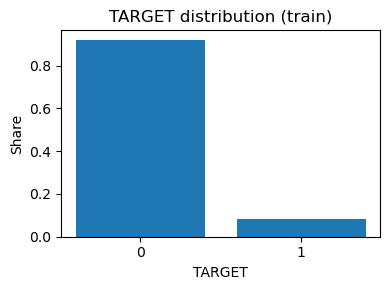

In [12]:
# EDA 1: TARGET distribution (train only)
y = train_joined["TARGET"].value_counts(normalize=True).sort_index()
plt.figure(figsize=(4,3))
plt.bar(y.index.astype(int).astype(str), y.values)
plt.xlabel("TARGET")
plt.ylabel("Share")
plt.title("TARGET distribution (train)")
plt.tight_layout()
plt.show()


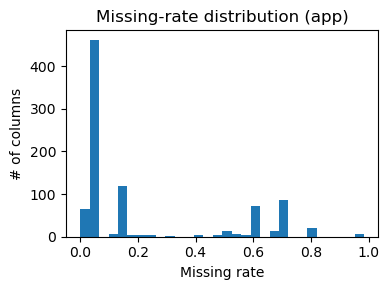

In [13]:
# EDA 2: Missing-rate distribution across ALL columns (app = train+test)
miss_rate = app.isna().mean()
plt.figure(figsize=(4,3))
plt.hist(miss_rate.values, bins=30)
plt.xlabel("Missing rate")
plt.ylabel("# of columns")
plt.title("Missing-rate distribution (app)")
plt.tight_layout()
plt.show()


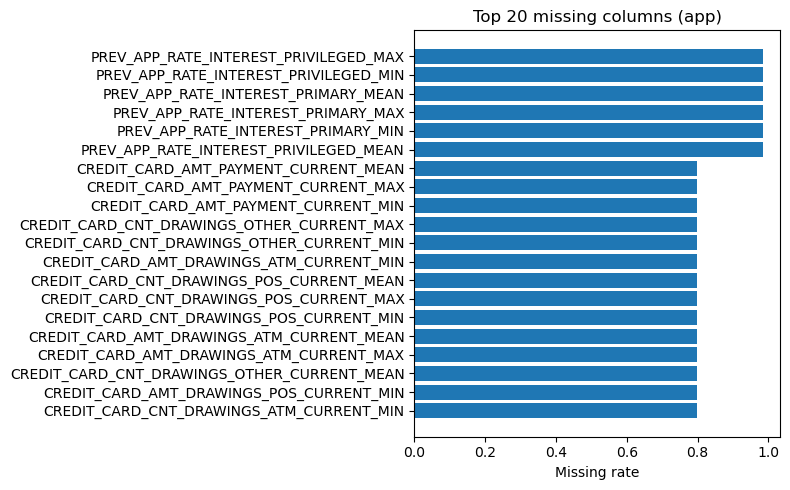

In [14]:
# EDA 3: Top missing columns (app)
top_miss = app.isna().mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(8,5))
plt.barh(top_miss.index[::-1], top_miss.values[::-1])
plt.xlabel("Missing rate")
plt.title("Top 20 missing columns (app)")
plt.tight_layout()
plt.show()


C:\Users\Zhewei Deng\AppData\Local\Temp\ipykernel_32700\2238647750.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


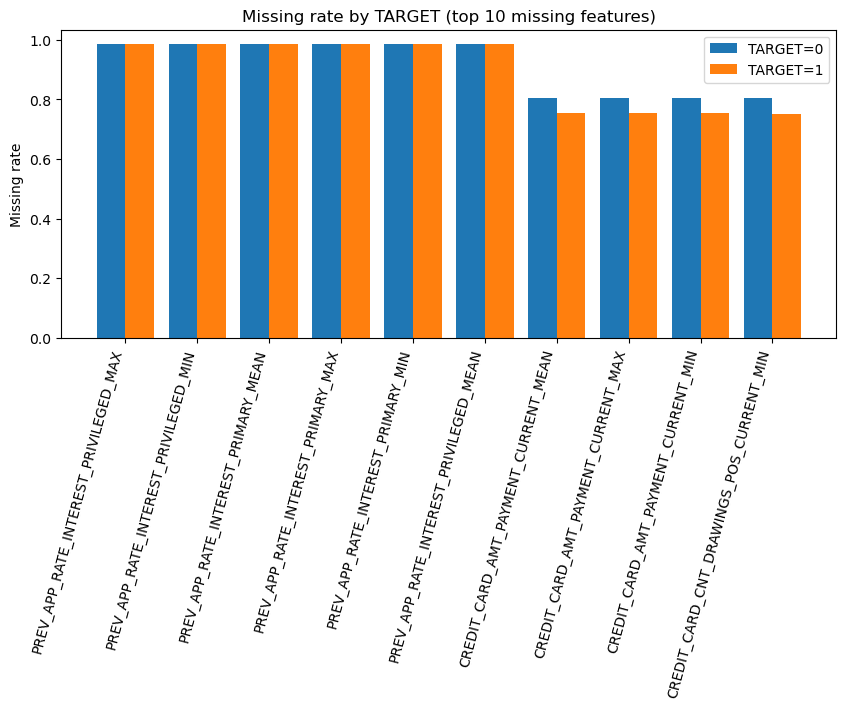

In [15]:
# EDA 4: Missing rate by TARGET for top-missing features (train only)
top_cols = train_joined.drop(columns=["TARGET"], errors="raise").isna().mean().sort_values(ascending=False).head(10).index

miss0 = train_joined.loc[train_joined["TARGET"]==0, top_cols].isna().mean()
miss1 = train_joined.loc[train_joined["TARGET"]==1, top_cols].isna().mean()

x = np.arange(len(top_cols))
w = 0.4
plt.figure(figsize=(10,4))
plt.bar(x - w/2, miss0.values, width=w, label="TARGET=0")
plt.bar(x + w/2, miss1.values, width=w, label="TARGET=1")
plt.xticks(x, top_cols, rotation=75, ha="right")
plt.ylabel("Missing rate")
plt.title("Missing rate by TARGET (top 10 missing features)")
plt.legend()
plt.tight_layout()
plt.show()


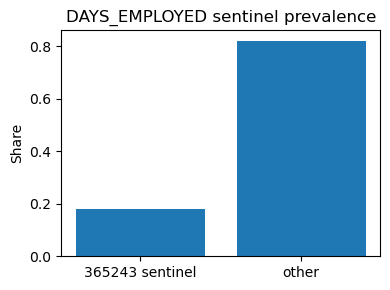

In [16]:
# EDA 5: DAYS_EMPLOYED sentinel value check (train only)
if "DAYS_EMPLOYED" in train_joined.columns:
    sentinel_share = (train_joined["DAYS_EMPLOYED"] == 365243).mean()
    plt.figure(figsize=(4,3))
    plt.bar(["365243 sentinel", "other"], [sentinel_share, 1 - sentinel_share])
    plt.ylabel("Share")
    plt.title("DAYS_EMPLOYED sentinel prevalence")
    plt.tight_layout()
    plt.show()
else:
    print("DAYS_EMPLOYED not found in train_joined")


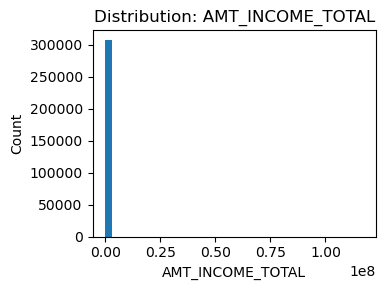

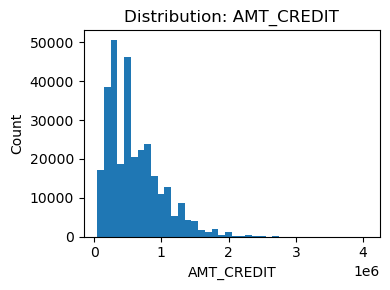

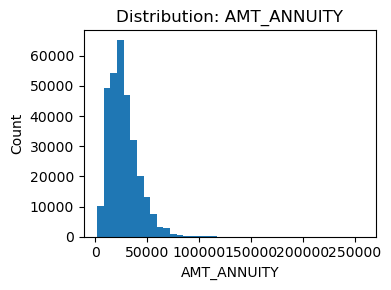

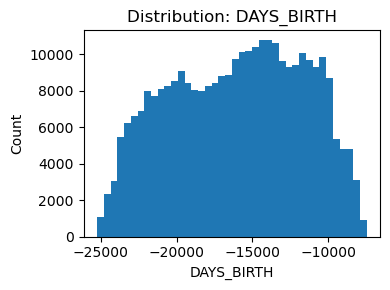

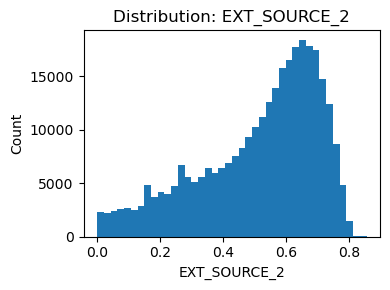

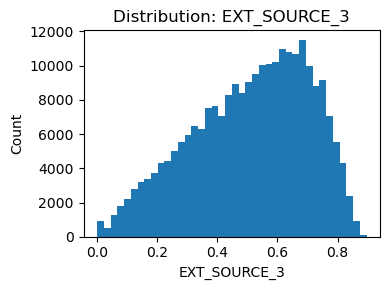

In [17]:
# EDA 6: Key numeric distributions (train only)
num_candidates = ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY","DAYS_BIRTH","EXT_SOURCE_2","EXT_SOURCE_3"]
num_cols = [c for c in num_candidates if c in train_joined.columns]

for c in num_cols:
    s = train_joined[c].dropna()
    plt.figure(figsize=(4,3))
    plt.hist(s.values, bins=40)
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.title(f"Distribution: {c}")
    plt.tight_layout()
    plt.show()


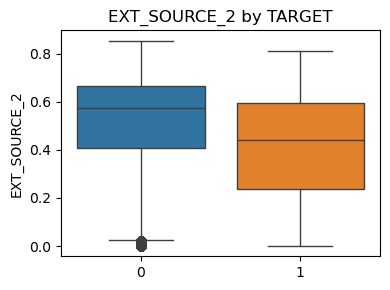

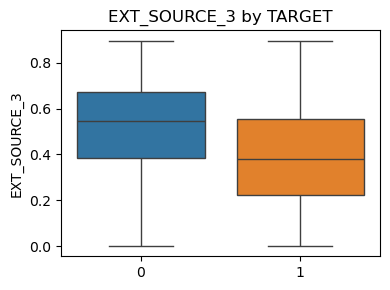

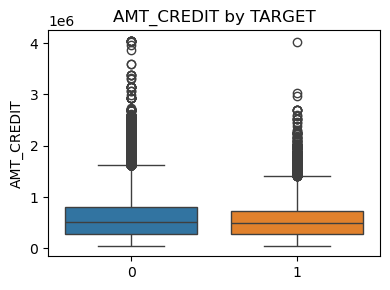

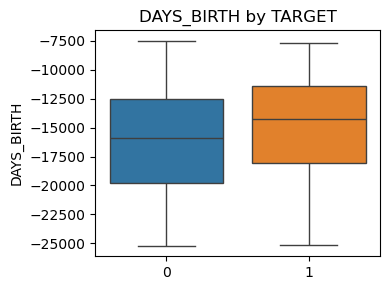

In [18]:
# EDA 7: Numeric vs TARGET (boxplot) for a few strong features
box_cols = [c for c in ["EXT_SOURCE_2","EXT_SOURCE_3","AMT_CREDIT","DAYS_BIRTH"] if c in train_joined.columns]

for c in box_cols:
    d0 = train_joined.loc[train_joined["TARGET"]==0, c].dropna()
    d1 = train_joined.loc[train_joined["TARGET"]==1, c].dropna()
    plt.figure(figsize=(4,3))
    sns.boxplot([d0.values, d1.values])
    plt.ylabel(c)
    plt.title(f"{c} by TARGET")
    plt.tight_layout()
    plt.show()


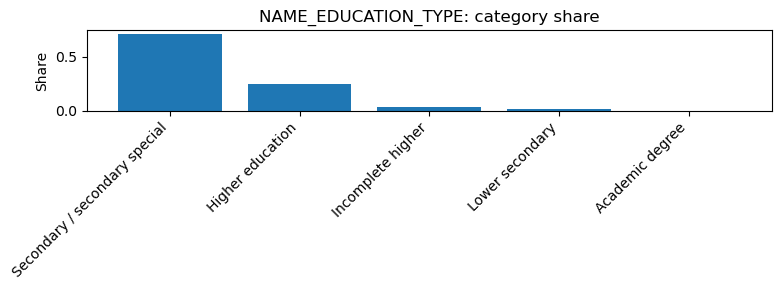

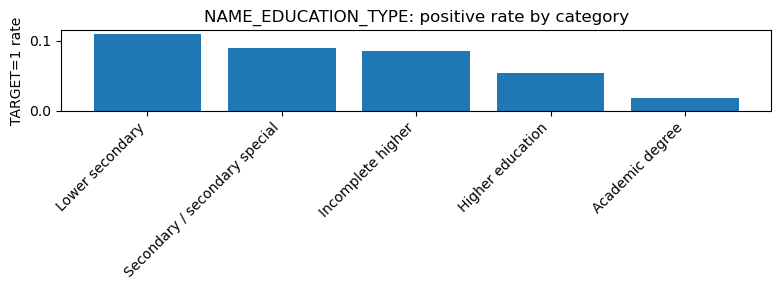

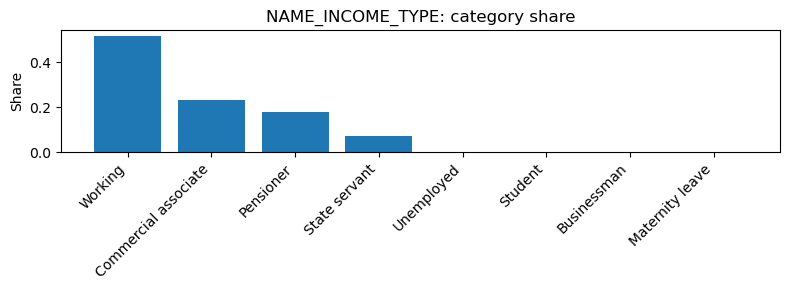

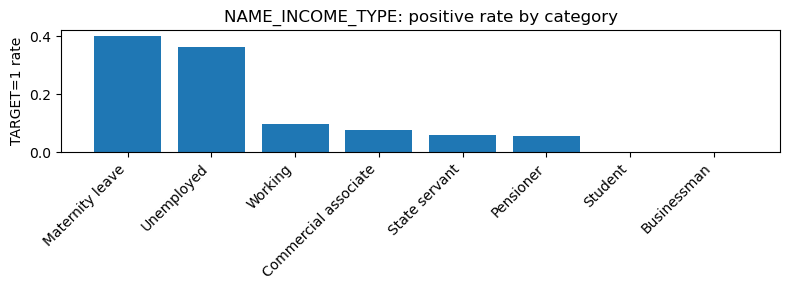

In [19]:
# EDA 8: Categorical frequency + positive rate (train only)
cat_cols = [c for c in ["NAME_EDUCATION_TYPE","NAME_INCOME_TYPE"] if c in train_joined.columns]

for c in cat_cols:
    tmp = train_joined[[c,"TARGET"]].copy()
    tmp[c] = tmp[c].astype("object").fillna("Missing")

    # top 12 categories + Other (避免图太长)
    top = tmp[c].value_counts().head(12).index
    tmp[c] = tmp[c].where(tmp[c].isin(top), "Other")

    prof = tmp.groupby(c)["TARGET"].agg(count="size", pos_rate="mean").reset_index()
    prof["share"] = prof["count"] / prof["count"].sum()
    prof = prof.sort_values("share", ascending=False)

    # share plot
    plt.figure(figsize=(8,3))
    plt.bar(prof[c].astype(str), prof["share"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Share")
    plt.title(f"{c}: category share")
    plt.tight_layout()
    plt.show()

    # pos rate plot (按 pos_rate 排序更有洞察)
    prof2 = prof.sort_values("pos_rate", ascending=False)
    plt.figure(figsize=(8,3))
    plt.bar(prof2[c].astype(str), prof2["pos_rate"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("TARGET=1 rate")
    plt.title(f"{c}: positive rate by category")
    plt.tight_layout()
    plt.show()


### Stage 3 - Model Matrix Initialization

**What this cell does**  
Builds raw training/test model matrices and the target vector.

**Inputs**  
`train_joined`, `test_joined`.

**Outputs**  
`X_train_raw`, `y_train`, `X_test_raw`.

**Notes / assumptions**  
ID and split-marker columns are excluded from model inputs.

In [20]:
DROP = ["TARGET", "SK_ID_CURR", "_is_train"]

# feature matrices: drop ids/labels if present
X_train_raw = train_joined.drop(columns=[c for c in DROP if c in train_joined.columns])
X_test_raw  = test_joined.drop(columns=[c for c in DROP if c in test_joined.columns], errors="ignore")

# target vector (train only)
y_train = train_joined["TARGET"].astype("int8")  # keep small dtype for memory

pd.DataFrame({
    "object": ["X_train_raw", "y_train", "X_test_raw"],
    "shape":  [X_train_raw.shape, y_train.shape, X_test_raw.shape],
})


,object,shape
0,X_train_raw,"(307511, 891)"
1,y_train,"(307511,)"
2,X_test_raw,"(48744, 891)"


### Stage 3 - Raw Feature Audit

**What this cell does**  
Runs a compact type and missingness audit on raw training features.

**Inputs**  
`X_train_raw`.

**Outputs**  
Data type counts and top missing-rate feature table.

**Notes / assumptions**  
This is a diagnostic-only checkpoint.

In [21]:
# dtype distribution (collapse things like "int64" vs "int64[pyarrow]" if any)
dtype_counts = (
    X_train_raw.dtypes.astype(str).str.split("(", n=1).str[0]
    .value_counts()
)

# top missing-rate columns
missing_top15 = (
    X_train_raw.isna().mean()
    .sort_values(ascending=False)
    .head(15)
    .to_frame("missing_rate")
)

display(dtype_counts.rename_axis("dtype_group").reset_index(name="count")) # dtype count table
display(missing_top15) # top-15 missing-rate table


,dtype_group,count
0,float64,836
1,int64,39
2,object,16


,missing_rate
PREV_APP_RATE_INTEREST_PRIVILEGED_MEAN,0.985012
PREV_APP_RATE_INTEREST_PRIVILEGED_MIN,0.985012
PREV_APP_RATE_INTEREST_PRIMARY_MEAN,0.985012
PREV_APP_RATE_INTEREST_PRIMARY_MAX,0.985012
PREV_APP_RATE_INTEREST_PRIVILEGED_MAX,0.985012
PREV_APP_RATE_INTEREST_PRIMARY_MIN,0.985012
CREDIT_CARD_AMT_PAYMENT_CURRENT_MEAN,0.801438
CREDIT_CARD_AMT_PAYMENT_CURRENT_MAX,0.801438
CREDIT_CARD_AMT_PAYMENT_CURRENT_MIN,0.801438
CREDIT_CARD_CNT_DRAWINGS_OTHER_CURRENT_MIN,0.801178


### Stage 3 - Train/Validation Split

**What this cell does**  
Splits raw training features into train and validation folds with stratification.

**Inputs**  
`X_train_raw`, `y_train`, `random_state`.

**Outputs**  
`X_tr_raw`, `X_val_raw`, `y_tr`, `y_val` and split diagnostics.

**Notes / assumptions**  
Stratified split preserves target balance.

In [22]:
# Core split: create train/validation folds with fixed randomness and stratification.
from sklearn.model_selection import train_test_split
random_state = 42
np.random.seed(random_state)

X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    X_train_raw, y_train,
    test_size=0.2,
    random_state=random_state,
    stratify=y_train
)

pd.DataFrame({
    "metric": ["X_tr_raw_shape", "X_val_raw_shape", "X_test_raw_shape", "y_tr_pos_rate", "y_val_pos_rate"],
    "value": [X_tr_raw.shape, X_val_raw.shape, X_test_raw.shape, float(pd.Series(y_tr).mean()), float(pd.Series(y_val).mean())]
})


,metric,value
0,X_tr_raw_shape,"(246008, 891)"
1,X_val_raw_shape,"(61503, 891)"
2,X_test_raw_shape,"(48744, 891)"
3,y_tr_pos_rate,0.080729
4,y_val_pos_rate,0.080728


### Stage 3 - High-Missing Feature Drop

**What this cell does**  
Drops columns exceeding a fixed missing-rate threshold based on train fold.

**Inputs**  
`X_tr_raw`, `X_val_raw`, `X_test_raw`.

**Outputs**  
`X_tr_step`, `X_val_step`, `X_test_step`, and drop diagnostics.

**Notes / assumptions**  
Threshold is fixed and evaluated on training data only.

In [23]:
THRESH = 0.65

# decide drops using TRAIN fold only (avoid leakage)
drop_cols = X_tr_raw.columns[X_tr_raw.isna().mean() > THRESH].tolist()

# apply the same drops to all splits
X_tr_step  = X_tr_raw.drop(columns=drop_cols).copy()
X_val_step = X_val_raw.drop(columns=drop_cols).copy()
X_test_step= X_test_raw.drop(columns=drop_cols).copy()

dropped_high_missing_cols = drop_cols  # keep for audit

pd.DataFrame({
    "metric": ["threshold", "n_cols_dropped", "tr_shape_after", "val_shape_after", "test_shape_after"],
    "value":  [THRESH, len(drop_cols), X_tr_step.shape, X_val_step.shape, X_test_step.shape],
})


,metric,value
0,threshold,0.65
1,n_cols_dropped,196
2,tr_shape_after,"(246008, 695)"
3,val_shape_after,"(61503, 695)"
4,test_shape_after,"(48744, 695)"


### Stage 4 - Feature Group Definitions

**What this cell does**  
Defines categorical, numeric, and domain-specific column groups for preprocessing.

**Inputs**  
`X_tr_step` columns.

**Outputs**  
Feature-group lists and counts.

**Notes / assumptions**  
Groups are derived from the train fold and reused downstream.

In [24]:
# feature families from current train-fold feature set
cat_cols = X_tr_step.select_dtypes(include=["object", "category"]).columns.tolist()  # categoricals for one-hot
num_cols = X_tr_step.select_dtypes(include=np.number).columns.tolist()              # numeric features

SOCIAL_CANDIDATES = [
    "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
]
BUREAU_CANDIDATES = [
    "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR",
]

# keep only columns that actually exist (robust to upstream drops)
social_cols = [c for c in SOCIAL_CANDIDATES if c in X_tr_step.columns]
bureau_cols = [c for c in BUREAU_CANDIDATES if c in X_tr_step.columns]
phone_col = "DAYS_LAST_PHONE_CHANGE" if "DAYS_LAST_PHONE_CHANGE" in X_tr_step.columns else None

pd.DataFrame({
    "group": ["cat_cols", "num_cols", "social_cols", "bureau_cols", "phone_col_present"],
    "count": [len(cat_cols), len(num_cols), len(social_cols), len(bureau_cols), int(phone_col is not None)],
})


,group,count
0,cat_cols,15
1,num_cols,680
2,social_cols,4
3,bureau_cols,6
4,phone_col_present,1


### Stage 4 - Missingness Indicator Engineering

**What this cell does**  
Adds binary flags indicating missing patterns for selected feature groups.

**Inputs**  
Step-1 filtered train/validation/test matrices and candidate feature lists.

**Outputs**  
Updated matrices plus indicator-count checks.

**Notes / assumptions**  
Indicators are created consistently across all splits.

In [25]:
# start from the same feature matrices
X_tr_step2, X_val_step2, X_test_step2 = X_tr_step.copy(), X_val_step.copy(), X_test_step.copy()
splits = (X_tr_step2, X_val_step2, X_test_step2)

indicator_cols = []

if social_cols:
    for df_ in splits:
        df_["SOCIAL_CIRCLE_MISSING"] = df_[social_cols].isna().any(axis=1).astype("uint8")  # any social NA -> 1
    indicator_cols.append("SOCIAL_CIRCLE_MISSING")

if bureau_cols:
    for df_ in splits:
        df_["CREDIT_BUREAU_MISSING"] = df_[bureau_cols].isna().any(axis=1).astype("uint8")  # any bureau NA -> 1
    indicator_cols.append("CREDIT_BUREAU_MISSING")

if phone_col:
    for df_ in splits:
        df_["DAYS_LAST_PHONE_CHANGE_MISSING"] = df_[phone_col].isna().astype("uint8")        # phone NA -> 1
    indicator_cols.append("DAYS_LAST_PHONE_CHANGE_MISSING")

pd.DataFrame({
    "indicator": indicator_cols,
    "tr_sum":  [int(X_tr_step2[c].sum()) for c in indicator_cols],
    "val_sum": [int(X_val_step2[c].sum()) for c in indicator_cols],
    "test_sum":[int(X_test_step2[c].sum()) for c in indicator_cols],
})


,indicator,tr_sum,val_sum,test_sum
0,SOCIAL_CIRCLE_MISSING,811,210,29
1,CREDIT_BUREAU_MISSING,33244,8275,6049
2,DAYS_LAST_PHONE_CHANGE_MISSING,1,0,0


,bucket,n_features,avg_missing_rate
0,0–5%,66,0.000310
1,5–20%,590,0.073462
2,20–60%,42,0.469369
3,60–100%,0,NaN


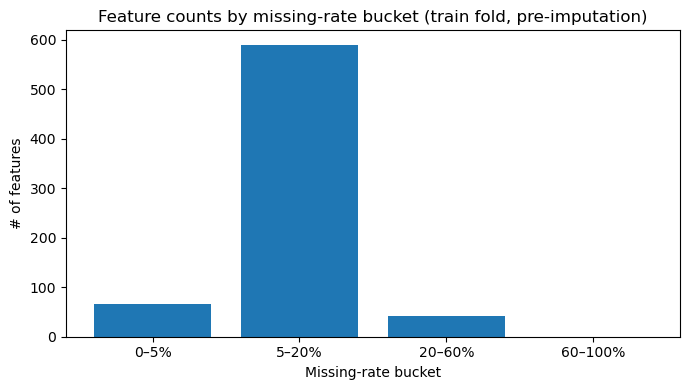

In [34]:
# Missing-rate buckets (BEFORE imputation) on train fold

miss_rate = X_tr_step2.isna().mean().sort_values(ascending=False)

bins = [0, 0.05, 0.20, 0.60, 1.0]
labels = ["0–5%", "5–20%", "20–60%", "60–100%"]

bucket = pd.cut(miss_rate, bins=bins, labels=labels, include_lowest=True)

bucket_summary = (
    pd.DataFrame({"missing_rate": miss_rate, "bucket": bucket})
      .groupby("bucket")
      .agg(n_features=("missing_rate", "size"),
           avg_missing_rate=("missing_rate", "mean"))
      .reset_index()
)

display(bucket_summary)

plt.figure(figsize=(7, 4))
plt.bar(bucket_summary["bucket"].astype(str), bucket_summary["n_features"])
plt.xlabel("Missing-rate bucket")
plt.ylabel("# of features")
plt.title("Feature counts by missing-rate bucket (train fold, pre-imputation)")
plt.tight_layout()
plt.show()


In [38]:
y = y_train.loc[X_tr_step2.index].astype(int).to_numpy()

lift = pd.DataFrame({
    "feature": X_tr_step2.columns,
    "missing_rate": X_tr_step2.isna().mean().values,
    "rate_if_default": [y[X_tr_step2[c].isna().to_numpy()].mean() for c in X_tr_step2.columns],
    "rate_if_not_default": [y[~X_tr_step2[c].isna().to_numpy()].mean() for c in X_tr_step2.columns],
})

lift["diff"] = lift["rate_if_default"] - lift["rate_if_not_default"]
lift = lift.sort_values("diff", ascending=False).reset_index(drop=True)

display(lift.head(30))


C:\Users\Zhewei Deng\AppData\Local\Temp\ipykernel_32700\250810133.py:6: RuntimeWarning: Mean of empty slice.
  "rate_if_default": [y[X_tr_step2[c].isna().to_numpy()].mean() for c in X_tr_step2.columns],
d:\PythonSoftware\Anaconda\envs\IEOR4525\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature,missing_rate,rate_if_default,rate_if_not_default,diff
0,BUREAU_DAYS_ENDDATE_FACT_MIN,0.250785,0.104919,0.072632,0.032287
1,BUREAU_DAYS_ENDDATE_FACT_MEAN,0.250785,0.104919,0.072632,0.032287
2,BUREAU_DAYS_ENDDATE_FACT_MAX,0.250785,0.104919,0.072632,0.032287
3,AMT_REQ_CREDIT_BUREAU_HOUR,0.135134,0.103387,0.077189,0.026198
4,AMT_REQ_CREDIT_BUREAU_DAY,0.135134,0.103387,0.077189,0.026198
5,AMT_REQ_CREDIT_BUREAU_WEEK,0.135134,0.103387,0.077189,0.026198
6,AMT_REQ_CREDIT_BUREAU_MON,0.135134,0.103387,0.077189,0.026198
7,AMT_REQ_CREDIT_BUREAU_QRT,0.135134,0.103387,0.077189,0.026198
8,AMT_REQ_CREDIT_BUREAU_YEAR,0.135134,0.103387,0.077189,0.026198
9,BUREAU_DAYS_CREDIT_ENDDATE_MAX,0.150637,0.101436,0.077057,0.024379


### Stage 4 - Missingness Imputation Rules

**What this cell does**  
Applies placeholder cleanup and fill strategies for numeric and categorical features.

**Inputs**  
`X_tr_step2`, `X_val_step2`, `X_test_step2`, and predefined column groups.

**Outputs**  
Imputed datasets and remaining-missing diagnostics.

**Notes / assumptions**  
Numeric medians are fit on the training fold.

In [26]:
X_tr_step3, X_val_step3, X_test_step3 = X_tr_step2.copy(), X_val_step2.copy(), X_test_step2.copy()
splits = (X_tr_step3, X_val_step3, X_test_step3)

# 1) Sentinel cleanup: DAYS_EMPLOYED == 365243 -> NaN (all splits)
for df_ in splits:
    if "DAYS_EMPLOYED" in df_.columns:
        df_.loc[df_["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan  # placeholder -> missing

# 2) Domain groups: fill missing with 0 (all splits)
if social_cols:
    for df_ in splits:
        df_[social_cols] = df_[social_cols].fillna(0)  # treat NA as 0 events

if bureau_cols:
    for df_ in splits:
        df_[bureau_cols] = df_[bureau_cols].fillna(0)  # treat NA as 0 requests

# 3) Categoricals: explicit missing token (all splits)
for df_ in splits:
    df_[cat_cols] = df_[cat_cols].fillna("Missing")  # consistent category for NA

# 4) Numerics: median impute fitted on TRAIN fold only, then apply to all splits
num_cols_fill = X_tr_step3.select_dtypes(include=np.number).columns  # numeric columns after step3 changes
medians = X_tr_step3[num_cols_fill].median()                         # fit on train fold only

X_tr_step3[num_cols_fill]  = X_tr_step3[num_cols_fill].fillna(medians)
X_val_step3[num_cols_fill] = X_val_step3[num_cols_fill].fillna(medians)
X_test_step3[num_cols_fill]= X_test_step3[num_cols_fill].fillna(medians)

pd.DataFrame({
    "dataset": ["train", "val", "test"],
    "missing_total": [
        int(X_tr_step3.isna().sum().sum()),
        int(X_val_step3.isna().sum().sum()),
        int(X_test_step3.isna().sum().sum()),
    ],
})


,dataset,missing_total
0,train,0
1,val,0
2,test,0


### Stage 4 - Outlier Clipping

**What this cell does**  
Computes train-fold percentile bounds and clips continuous numeric features.

**Inputs**  
`X_tr_step3`, `X_val_step3`, `X_test_step3`.

**Outputs**  
Clipped datasets and outlier bound diagnostics.

**Notes / assumptions**  
Bounds are p1/p99 from training fold only.

In [27]:
# train/val/test copies for this step
X_tr_step4, X_val_step4, X_test_step4 = X_tr_step3.copy(), X_val_step3.copy(), X_test_step3.copy()
splits = (X_tr_step4, X_val_step4, X_test_step4)

# pick continuous-ish numeric columns to winsorize (exclude missing flags + document flags + binary-ish cols)
num_cols = X_tr_step4.select_dtypes(include=np.number).columns
continuous_candidates = [
    c for c in num_cols
    if not c.endswith("_MISSING")
    and not c.startswith("FLAG_")
    and not c.startswith("FLAG_DOCUMENT_")
    and X_tr_step4[c].nunique(dropna=True) > 2
]

# compute train-fold 1% / 99% bounds per feature (avoid leakage)
p1, p99 = X_tr_step4[continuous_candidates].quantile([0.01, 0.99]).values

# apply clipping to all splits using train bounds
for df_ in splits:
    df_[continuous_candidates] = df_[continuous_candidates].clip(p1, p99, axis=1)

outlier_bounds = pd.DataFrame({"feature": continuous_candidates, "p1": p1, "p99": p99})
outlier_clipped_cols = continuous_candidates
outlier_clipped_cols_count = len(outlier_clipped_cols)

outlier_bounds.head(10)


,feature,p1,p99
0,CNT_CHILDREN,0.000000,3.000000e+00
1,AMT_INCOME_TOTAL,45000.000000,4.725000e+05
2,AMT_CREDIT,76410.000000,1.862802e+06
3,AMT_ANNUITY,6187.500000,7.003224e+04
4,AMT_GOODS_PRICE,67500.000000,1.800000e+06
5,REGION_POPULATION_RELATIVE,0.002134,7.250800e-02
6,DAYS_BIRTH,-24412.000000,-8.260000e+03
7,DAYS_EMPLOYED,-10899.860000,-1.160000e+02
8,DAYS_REGISTRATION,-13903.000000,-5.100000e+01
9,DAYS_ID_PUBLISH,-5447.000000,-6.200000e+01


### Stage 4 - Scaling and Normalization

**What this cell does**  
Builds preprocessing transformers and applies scaling to selected numeric columns.

**Inputs**  
`X_tr_step6`, `X_val_step6`, `X_test_step6`.

**Outputs**  
`X_tr_scaled`, `X_val_scaled`, `X_test_scaled` with aligned feature names.

**Notes / assumptions**  
Transformer is fit on training fold and reused on validation/test.

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1) One-hot: train defines the feature space
X_tr_step6  = pd.get_dummies(X_tr_step4,  columns=cat_cols, dtype=np.uint8)
X_val_step6 = pd.get_dummies(X_val_step4, columns=cat_cols, dtype=np.uint8)
X_test_step6= pd.get_dummies(X_test_step4,columns=cat_cols, dtype=np.uint8)

# Align val/test to train dummy columns (missing -> 0, extras dropped)
X_val_step6  = X_val_step6.reindex(columns=X_tr_step6.columns, fill_value=0)
X_test_step6 = X_test_step6.reindex(columns=X_tr_step6.columns, fill_value=0)

# 2) Scale continuous numeric cols only (exclude uint8 one-hot + binary-ish)
num_cols = X_tr_step6.select_dtypes(include=np.number).columns
scale_cols = [c for c in num_cols if (X_tr_step6[c].dtype != np.uint8) and (X_tr_step6[c].nunique() > 2)]
pass_cols  = [c for c in X_tr_step6.columns if c not in scale_cols]

scaler = Pipeline([
    ("std", StandardScaler()),  # fit on train fold only
    ("mm",  MinMaxScaler()),    # fit on train fold only
])

preprocess = ColumnTransformer(
    [("scale", scaler, scale_cols),
     ("pass", "passthrough", pass_cols)],
    verbose_feature_names_out=False,
)

# 3) Fit on train, transform val/test
X_tr_scaled  = preprocess.fit_transform(X_tr_step6)
X_val_scaled = preprocess.transform(X_val_step6)
X_test_scaled= preprocess.transform(X_test_step6)

# 4) Back to DataFrames with stable feature names
cols = preprocess.get_feature_names_out()
X_tr_scaled  = pd.DataFrame(X_tr_scaled,  columns=cols, index=X_tr_step6.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=cols, index=X_val_step6.index)
X_test_scaled= pd.DataFrame(X_test_scaled,columns=cols, index=X_test_step6.index)


### Stage 5 - Exploratory Data Analysis 

**What this cell does**  
Runs compact EDA plots on the non-SMOTE training fold.

**Inputs**  
`X_tr_scaled`, `y_tr`, `scale_cols`.

**Outputs**  
Target distribution, feature histograms, and a top-correlation heatmap.

**Notes / assumptions**  
Sampling is used for speed on large data.

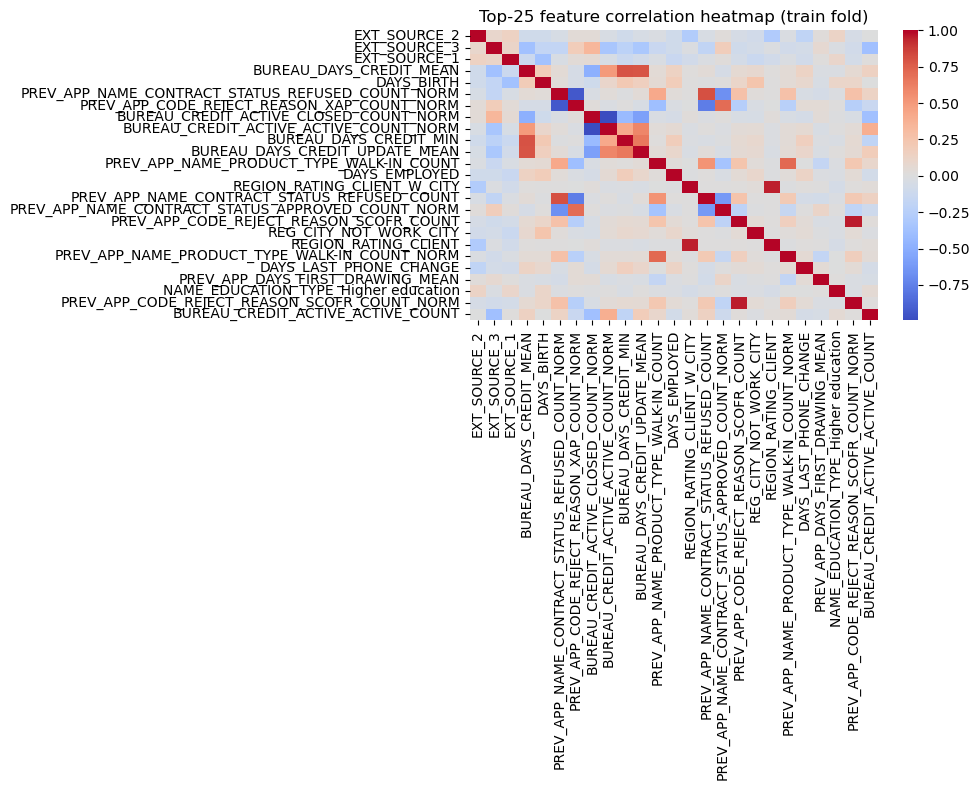

In [29]:
# EDA frame: features + target (train fold only)
df_eda = X_tr_scaled.join(pd.Series(y_tr, index=X_tr_scaled.index, name="TARGET"))

# sample up to 50k rows for speed (keep randomness fixed)
if len(df_eda) > 50000:
    df_eda = df_eda.sample(n=50000, random_state=random_state)

# correlation screen: rank features by |corr(feature, TARGET)| and plot heatmap
num_cols = df_eda.select_dtypes(include=np.number).columns.drop("TARGET")
top = df_eda[num_cols].corrwith(df_eda["TARGET"]).abs().sort_values(ascending=False).head(25).index.tolist()
if top:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_eda[top].corr(), cmap="coolwarm", center=0)
    plt.title("Top-25 feature correlation heatmap (train fold)")
    plt.tight_layout()
    plt.show()


,feature,auc,signal_strength
0,EXT_SOURCE_2,0.346664,0.653336
1,EXT_SOURCE_3,0.350298,0.649702
2,BUREAU_DAYS_CREDIT_MEAN,0.592198,0.592198
3,DAYS_BIRTH,0.585953,0.585953
4,EXT_SOURCE_1,0.419105,0.580895
5,DAYS_EMPLOYED,0.577070,0.577070
6,BUREAU_CREDIT_ACTIVE_CLOSED_COUNT_NORM,0.423002,0.576998
7,BUREAU_DAYS_CREDIT_UPDATE_MEAN,0.576665,0.576665
8,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT_NORM,0.575239,0.575239
9,BUREAU_DAYS_CREDIT_MAX,0.573544,0.573544


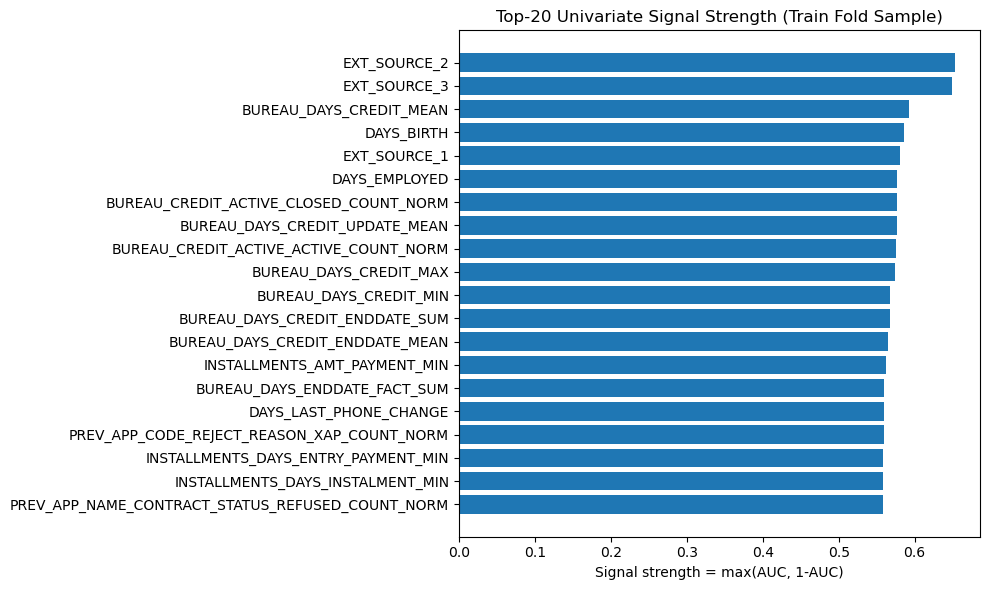

In [31]:
from sklearn.metrics import roc_auc_score

y = df_eda["TARGET"].astype(int)

num_cols = df_eda.select_dtypes(include=np.number).columns
num_cols = [c for c in num_cols if c != "TARGET"]

univariate_auc = pd.DataFrame({
    "feature": num_cols,
    "auc": [roc_auc_score(y, df_eda[c]) for c in num_cols]
})
univariate_auc["signal_strength"] = univariate_auc["auc"].apply(lambda a: max(a, 1 - a))
univariate_auc = univariate_auc.sort_values("signal_strength", ascending=False).reset_index(drop=True)

display(univariate_auc.head(30))

topk = 20
plot_df = univariate_auc.head(topk).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(plot_df["feature"], plot_df["signal_strength"])
plt.xlabel("Signal strength = max(AUC, 1-AUC)")
plt.title(f"Top-{topk} Univariate Signal Strength (Train Fold Sample)")
plt.tight_layout()
plt.show()


,indicator,rate_if_1,rate_if_0,diff_1_minus_0
0,CREDIT_BUREAU_MISSING,0.103963,0.077001,0.026962
1,SOCIAL_CIRCLE_MISSING,0.017045,0.080804,-0.063759
2,DAYS_LAST_PHONE_CHANGE_MISSING,NaN,0.080580,NaN


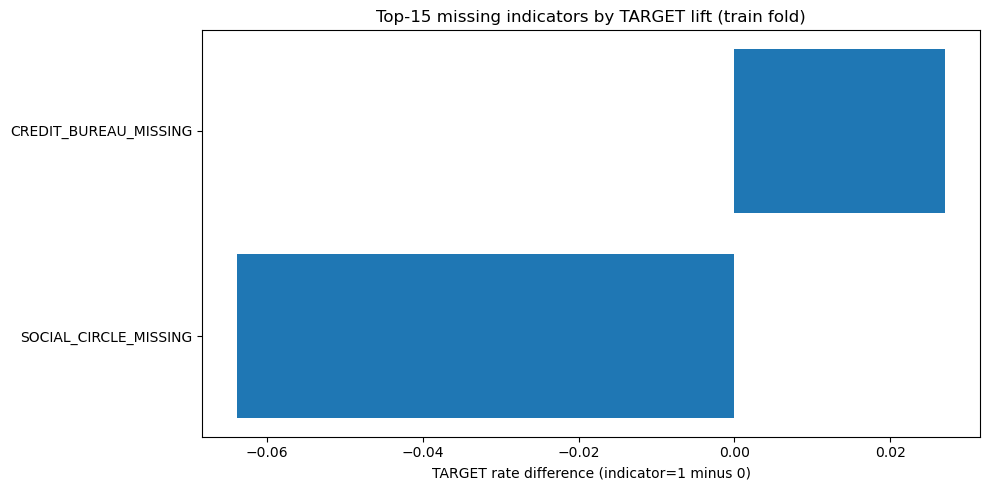

In [32]:
# Missing indicator usefulness: TARGET rate when indicator = 1 vs 0

ind_effect = []
for c in indicator_cols:
    ind_effect.append({
        "indicator": c,
        "rate_if_1": df_eda.loc[df_eda[c] == 1, "TARGET"].mean(),
        "rate_if_0": df_eda.loc[df_eda[c] == 0, "TARGET"].mean(),
        "diff_1_minus_0": df_eda.loc[df_eda[c] == 1, "TARGET"].mean() - df_eda.loc[df_eda[c] == 0, "TARGET"].mean()
    })

ind_effect = pd.DataFrame(ind_effect).sort_values("diff_1_minus_0", ascending=False).reset_index(drop=True)
display(ind_effect.head(30))

topk = 15
plot_df = ind_effect.head(topk).iloc[::-1]

plt.figure(figsize=(10, 5))
plt.barh(plot_df["indicator"], plot_df["diff_1_minus_0"])
plt.xlabel("TARGET rate difference (indicator=1 minus 0)")
plt.title(f"Top-{topk} missing indicators by TARGET lift (train fold)")
plt.tight_layout()
plt.show()


### Stage 5 - Processing Summary and Feature Ledger

**What this cell does**  
Builds pipeline-step summaries and a per-feature treatment ledger.

**Inputs**  
Intermediate artifacts from missingness handling, encoding, clipping, and scaling.

**Outputs**  
`processing_summary` and `feature_treatment_ledger` tables.

**Notes / assumptions**  
Rules are train-fold derived to avoid leakage.

In [29]:
# --- Processing summary (robust to whether SMOTE has run yet) ---
summary_rows = [
    {"step": "high-missing drop", "details": f"threshold={THRESH}", "value": len(drop_cols)},
    {"step": "indicators", "details": ", ".join(indicator_cols) if len(indicator_cols) > 0 else "none", "value": len(indicator_cols)},
    {"step": "imputation", "details": "group=0, cat=Missing, num=train-fold median", "value": len(num_cols_fill)},
    {"step": "outlier clipping", "details": "p1=0.01, p99=0.99 (fit on train fold)", "value": outlier_clipped_cols_count},
    {"step": "binary encoding", "details": "disabled_use_one_hot_for_all_categoricals", "value": 0},
    {"step": "one-hot", "details": "pd.get_dummies + reindex to train-fold columns", "value": X_tr_step6.shape[1]},
    {"step": "scaling+normalization", "details": "fit on train fold only (StandardScaler + MinMaxScaler)", "value": len(scale_cols)},
    {"step": "SMOTE", "details": "pending_run_after_feature_selection", "value": 0},
    {
        "step": "final checks",
        "details": "missing checks on scaled matrices",
        "value": int(X_tr_scaled.isna().sum().sum()) + int(X_val_scaled.isna().sum().sum()) + int(X_test_scaled.isna().sum().sum()),
    },
]

processing_summary = pd.DataFrame(summary_rows)


#### Stage 5.1 - Feature Ledger Rule Assignment

**What this cell does**  
Defines the original feature space and assigns treatment rules row-by-row.

**Inputs**  
Raw train-fold features and preprocessing rule artifacts.

**Outputs**  
`ledger_rows` base entries for original features.

**Notes / assumptions**  
Rules reflect train-fold derived preprocessing decisions.

In [30]:
# --- Feature treatment ledger ---
# Define "original feature space" as the RAW train fold columns BEFORE any engineered additions.
# This avoids undefined train_joined and keeps leakage-free alignment with fitted rules.
orig_features = X_tr_raw.copy()

orig_dtype = orig_features.dtypes.astype(str)
orig_missing = orig_features.isna().mean()

ledger_rows = []
for f in orig_features.columns:
    if f == "SK_ID_CURR":
        group = "id"
        treatment = "dropped_from_model_matrix"
        rule = "primary key not modeled"
    elif f in drop_cols:
        group = "dropped_high_missing"
        treatment = "dropped"
        rule = f"missing_rate>{THRESH} (computed on train fold)"
    elif f in cat_cols:
        group = "categorical"
        treatment = "fill_missing + one_hot"
        rule = "Missing token + pandas get_dummies (train-fold column space)"
    elif f in outlier_clipped_cols:
        group = "numeric_continuous"
        treatment = "median_fill + clip_p1_p99 + scale_norm"
        rule = "params fit on train fold"
    elif f in num_cols_fill:
        group = "numeric_other"
        treatment = "median_fill"
        rule = "train-fold median"
    else:
        group = "numeric_other" if pd.api.types.is_numeric_dtype(orig_features[f]) else "categorical"
        treatment = "kept"
        rule = "no special rule"

    ledger_rows.append({
        "feature": f,
        "dtype": orig_dtype.get(f, "unknown"),
        "missing_rate_train_fold": float(orig_missing.get(f, 0.0)),
        "treatment": treatment,
        "rule": rule,
        "group": group,
    })

#### Stage 5.2 - Engineered Feature Ledger Finalization

**What this cell does**  
Appends engineered indicator metadata and materializes/display final summary tables.

**Inputs**  
`ledger_rows`, `indicator_cols`, and `processing_summary`.

**Outputs**  
`feature_treatment_ledger` and rendered diagnostics.

**Notes / assumptions**  
Engineered indicators are tracked separately from raw-origin features.

In [31]:
# Add engineered indicator features as separate ledger entries (since they are not in orig_features)
for ind in indicator_cols:
    ledger_rows.append({
        "feature": ind,
        "dtype": "uint8",
        "missing_rate_train_fold": 0.0,
        "treatment": "engineered_indicator",
        "rule": "created pre-imputation as missing mechanism flag",
        "group": "engineered",
    })

feature_treatment_ledger = pd.DataFrame(ledger_rows)

display(processing_summary)
display(feature_treatment_ledger.head(30))

,step,details,value
0,high-missing drop,threshold=0.65,196
1,indicators,"SOCIAL_CIRCLE_MISSING, CREDIT_BUREAU_MISSING, ...",3
2,imputation,"group=0, cat=Missing, num=train-fold median",683
3,outlier clipping,"p1=0.01, p99=0.99 (fit on train fold)",588
4,binary encoding,disabled_use_one_hot_for_all_categoricals,0
5,one-hot,pd.get_dummies + reindex to train-fold columns,824
6,scaling+normalization,fit on train fold only (StandardScaler + MinMa...,423
7,SMOTE,pending_run_after_feature_selection,0
8,final checks,missing checks on scaled matrices,0


,feature,dtype,missing_rate_train_fold,treatment,rule,group
0,NAME_CONTRACT_TYPE,object,0.000000,fill_missing + one_hot,Missing token + pandas get_dummies (train-fold...,categorical
1,CODE_GENDER,object,0.000000,fill_missing + one_hot,Missing token + pandas get_dummies (train-fold...,categorical
2,FLAG_OWN_CAR,object,0.000000,fill_missing + one_hot,Missing token + pandas get_dummies (train-fold...,categorical
3,FLAG_OWN_REALTY,object,0.000000,fill_missing + one_hot,Missing token + pandas get_dummies (train-fold...,categorical
4,CNT_CHILDREN,int64,0.000000,median_fill + clip_p1_p99 + scale_norm,params fit on train fold,numeric_continuous
5,AMT_INCOME_TOTAL,float64,0.000000,median_fill + clip_p1_p99 + scale_norm,params fit on train fold,numeric_continuous
6,AMT_CREDIT,float64,0.000000,median_fill + clip_p1_p99 + scale_norm,params fit on train fold,numeric_continuous
7,AMT_ANNUITY,float64,0.000041,median_fill + clip_p1_p99 + scale_norm,params fit on train fold,numeric_continuous
8,AMT_GOODS_PRICE,float64,0.000898,median_fill + clip_p1_p99 + scale_norm,params fit on train fold,numeric_continuous
9,NAME_TYPE_SUITE,object,0.004183,fill_missing + one_hot,Missing token + pandas get_dummies (train-fold...,categorical


### Stage 5 - Final Matrix Consistency Checks

**What this cell does**  
Validates matrix alignment, data types, and final feature counts.

**Inputs**  
Scaled train/validation/test matrices and associated labels.

**Outputs**  
A final checks table and first feature-name preview.

**Notes / assumptions**  
Designed to work before or after SMOTE.

In [32]:
# Final assertions for modelling-ready matrices (works before/after SMOTE by swapping X_train_check/y_train_check)
X_train_check, y_train_check, train_name = X_tr_scaled, y_tr, "X_tr_scaled"
X_val_check, y_val_check = X_val_scaled, y_val
X_test_check = X_test_scaled

def non_numeric_cols(df):
    return [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]  # model matrices should be numeric-only

final_non_numeric_tr   = non_numeric_cols(X_train_check)
final_non_numeric_val  = non_numeric_cols(X_val_check)
final_non_numeric_test = non_numeric_cols(X_test_check)


#### Stage 5.3 - Final Assertion Reporting

**What this cell does**  
Renders final matrix checks and prints a feature-name preview.

**Inputs**  
Prepared check matrices and metadata counts.

**Outputs**  
Final diagnostics table, first-20 feature names, and memory cleanup call.

**Notes / assumptions**  
Column alignment equality is validated explicitly.

In [33]:
# Core validation report: render matrix consistency checks.
display(pd.DataFrame({
    "metric": [
        f"{train_name}_shape",
        "y_train_shape",
        "X_val_scaled_shape",
        "y_val_shape",
        "X_test_scaled_shape",
        "final_feature_count",
        "outlier_clipped_cols_count",
        "non_numeric_cols_count_train",
        "non_numeric_cols_count_val",
        "non_numeric_cols_count_test",
        "aligned_cols_val",
        "aligned_cols_test",
    ],
    "value": [
        X_train_check.shape,
        pd.Series(y_train_check).shape,
        X_val_check.shape,
        pd.Series(y_val_check).shape,
        X_test_check.shape,
        X_train_check.shape[1],
        outlier_clipped_cols_count,
        len(final_non_numeric_tr),
        len(final_non_numeric_val),
        len(final_non_numeric_test),
        list(X_train_check.columns) == list(X_val_check.columns),
        list(X_train_check.columns) == list(X_test_check.columns),
    ],
}))

print("first_20_columns:", X_train_check.columns[:20].to_list())

gc.collect()

,metric,value
0,X_tr_scaled_shape,"(246008, 824)"
1,y_train_shape,"(246008,)"
2,X_val_scaled_shape,"(61503, 824)"
3,y_val_shape,"(61503,)"
4,X_test_scaled_shape,"(48744, 824)"
5,final_feature_count,824
6,outlier_clipped_cols_count,588
7,non_numeric_cols_count_train,0
8,non_numeric_cols_count_val,0
9,non_numeric_cols_count_test,0


first_20_columns: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG']


9541

### Stage 6 - Low-Information Feature Removal

**What this cell does**  
Removes constant and near-constant low-information features.

**Inputs**  
`X_tr_scaled`, `X_val_scaled`, `X_test_scaled`.

**Outputs**  
Reduced matrices and feature-drop diagnostics.

**Notes / assumptions**  
Near-constant checks focus on discrete/binary-like columns.

In [34]:
orig_feature_count = X_tr_scaled.shape[1]

# train-fold uniqueness profile
nunique_train = X_tr_scaled.nunique(dropna=False)

# 1) Always drop true constants (nunique <= 1)
drop_constant_cols = nunique_train[nunique_train <= 1].index.tolist()

# 2) Only screen "near-constant" on discrete/low-cardinality columns
INT_DTYPES = {"uint8", "int8", "int16", "int32", "int64"}
discrete_cols = []
for c in X_tr_scaled.columns:
    s = X_tr_scaled[c]
    if not pd.api.types.is_numeric_dtype(s):
        continue
    if int(nunique_train[c]) <= 10 or str(s.dtype) in INT_DTYPES:
        discrete_cols.append(c)

# dominant share per discrete col (train fold only)
dominant_share = {}
for c in discrete_cols:
    s = X_tr_scaled[c]
    if str(s.dtype) in INT_DTYPES and s.nunique(dropna=False) <= 2:
        # binary-like: dominant share = max(p(1), p(0)); mean approximates p(1)
        m = float(pd.to_numeric(s, errors="coerce").fillna(0).mean())
        dominant_share[c] = max(m, 1.0 - m)
    else:
        # general discrete: take top category share
        dominant_share[c] = float(s.value_counts(dropna=False, normalize=True).iloc[0])

dom_share_s = pd.Series(dominant_share)
drop_near_constant_cols = dom_share_s[dom_share_s >= 0.999].index.tolist()

drop_low_info_cols = sorted(set(drop_constant_cols) | set(drop_near_constant_cols))

# apply drops to all splits (expect identical feature space at this point)
X_tr_red  = X_tr_scaled.drop(columns=drop_low_info_cols)
X_val_red = X_val_scaled.drop(columns=drop_low_info_cols)
X_test_red= X_test_scaled.drop(columns=drop_low_info_cols)


#### Stage 6.1 - Low-Information Diagnostics

**What this cell does**  
Builds reason tags and reports which low-information features were dropped.

**Inputs**  
`drop_low_info_cols`, `drop_constant_cols`, `dom_share_s`.

**Outputs**  
`dropped_low_info_df` and reduced-matrix shape summary.

**Notes / assumptions**  
This cell is reporting-only after the drop set is finalized.

In [35]:
orig_feature_count = X_tr_scaled.shape[1]

# train-fold uniqueness profile
nunique_train = X_tr_scaled.nunique(dropna=False)

# 1) Always drop true constants (nunique <= 1)
drop_constant_cols = nunique_train[nunique_train <= 1].index.tolist()

# 2) Only screen "near-constant" on discrete/low-cardinality columns
INT_DTYPES = {"uint8", "int8", "int16", "int32", "int64"}
discrete_cols = []
for c in X_tr_scaled.columns:
    s = X_tr_scaled[c]
    if not pd.api.types.is_numeric_dtype(s):
        continue
    if int(nunique_train[c]) <= 10 or str(s.dtype) in INT_DTYPES:
        discrete_cols.append(c)

# dominant share per discrete col (train fold only)
dominant_share = {}
for c in discrete_cols:
    s = X_tr_scaled[c]
    if str(s.dtype) in INT_DTYPES and s.nunique(dropna=False) <= 2:
        # binary-like: dominant share = max(p(1), p(0)); mean approximates p(1)
        m = float(pd.to_numeric(s, errors="coerce").fillna(0).mean())
        dominant_share[c] = max(m, 1.0 - m)
    else:
        # general discrete: take top category share
        dominant_share[c] = float(s.value_counts(dropna=False, normalize=True).iloc[0])

dom_share_s = pd.Series(dominant_share)
drop_near_constant_cols = dom_share_s[dom_share_s >= 0.999].index.tolist()

drop_low_info_cols = sorted(set(drop_constant_cols) | set(drop_near_constant_cols))

# apply drops to all splits (expect identical feature space at this point)
X_tr_red  = X_tr_scaled.drop(columns=drop_low_info_cols)
X_val_red = X_val_scaled.drop(columns=drop_low_info_cols)
X_test_red= X_test_scaled.drop(columns=drop_low_info_cols)


### Stage 6 - Correlation-Based Feature Pruning

**What this cell does**  
Drops one feature from highly correlated continuous feature pairs using train-fold statistics.

**Inputs**  
`X_tr_red`, `X_val_red`, `X_test_red`.

**Outputs**  
`X_tr_sel`, `X_val_sel`, `X_test_sel`, and dropped-pair diagnostics.

**Notes / assumptions**  
Correlation is computed on train fold (sampled if very large).

In [36]:
CORR_THRESHOLD = 0.98
X_tr_for_corr = X_tr_red  # train fold only (pre-SMOTE)

# candidates: numeric, non-binary, non-uint8 (avoid one-hot dummies)
candidate_cols = [
    c for c in X_tr_for_corr.columns
    if pd.api.types.is_numeric_dtype(X_tr_for_corr[c])
    and X_tr_for_corr[c].nunique(dropna=False) > 2
    and str(X_tr_for_corr[c].dtype) != "uint8"
]

# sample for speed if needed
X_corr = (
    X_tr_for_corr[candidate_cols].sample(50000, random_state= 42)
    if len(X_tr_for_corr) > 50000
    else X_tr_for_corr[candidate_cols]
)

corr_drop_pairs, corr_drop_set = [], set()

if len(candidate_cols) >= 2:
    corr_abs = X_corr.corr().abs()
    cols = corr_abs.columns.tolist()

    # keep-first policy: for any highly-correlated pair, drop the later column
    for i, kept in enumerate(cols):
        if kept in corr_drop_set:
            continue
        for j in range(i + 1, len(cols)):
            dropped = cols[j]
            if dropped in corr_drop_set:
                continue
            corr_val = float(corr_abs.iat[i, j])
            if corr_val > CORR_THRESHOLD:
                corr_drop_set.add(dropped)
                corr_drop_pairs.append({
                    "dropped_feature": dropped,
                    "kept_feature": kept,
                    "corr_value": corr_val,
                })

corr_drop_cols = sorted(corr_drop_set)
corr_drop_df = pd.DataFrame(corr_drop_pairs).sort_values("corr_value", ascending=False)

# apply drops to all splits (still pre-SMOTE)
X_tr_sel  = X_tr_red.drop(columns=corr_drop_cols)
X_val_sel = X_val_red.drop(columns=corr_drop_cols)
X_test_sel= X_test_red.drop(columns=corr_drop_cols)


#### Stage 6.2 - Correlation Pruning Diagnostics

**What this cell does**  
Displays top correlation drop pairs and shape impact after pruning.

**Inputs**  
`corr_drop_df`, selected train/validation/test matrices.

**Outputs**  
Correlation-drop preview and feature-count summary.

**Notes / assumptions**  
Runs after correlation-based drop set is computed.

In [37]:
# preview strongest correlation-based drops
display(corr_drop_df.head(20))

pd.DataFrame({
    "metric": ["corr_threshold", "corr_drop_count", "train_sel_shape", "val_sel_shape", "test_sel_shape"],
    "value":  [CORR_THRESHOLD, len(corr_drop_cols), X_tr_sel.shape, X_val_sel.shape, X_test_sel.shape],
})


,dropped_feature,kept_feature,corr_value
34,PREV_APP_NAME_CASH_LOAN_PURPOSE_XAP_COUNT_NORM,PREV_APP_NAME_CONTRACT_TYPE_CASH LOANS_COUNT_NORM,1.000000
37,PREV_APP_CODE_REJECT_REASON_CLIENT_COUNT_NORM,PREV_APP_NAME_CONTRACT_STATUS_UNUSED OFFER_COU...,1.000000
36,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_Y_COUNT_NORM,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_N_COUNT_NORM,1.000000
45,INSTALLMENTS_DAYS_ENTRY_PAYMENT_SUM,INSTALLMENTS_DAYS_INSTALMENT_SUM,0.999959
44,INSTALLMENTS_DAYS_ENTRY_PAYMENT_MIN,INSTALLMENTS_DAYS_INSTALMENT_MIN,0.999954
33,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_SUM,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_MAX,0.999912
29,PREV_APP_AMT_GOODS_PRICE_SUM,PREV_APP_AMT_APPLICATION_SUM,0.999866
42,INSTALLMENTS_DAYS_ENTRY_PAYMENT_MEAN,INSTALLMENTS_DAYS_INSTALMENT_MEAN,0.999786
32,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_FIRST_DUE_MAX,0.999694
27,PREV_APP_AMT_GOODS_PRICE_MAX,PREV_APP_AMT_APPLICATION_MAX,0.999583


,metric,value
0,corr_threshold,0.98
1,corr_drop_count,48
2,train_sel_shape,"(246008, 557)"
3,val_sel_shape,"(61503, 557)"
4,test_sel_shape,"(48744, 557)"


### Stage 7 - SMOTE Resampling

**What this cell does**  
Applies SMOTE on the post-selection training matrix only.

**Inputs**  
`X_tr_sel`, `y_tr`, `random_state`.

**Outputs**  
`X_tr_res`, `y_tr_res`, and a class-balance summary table.

**Notes / assumptions**  
Validation and test matrices are not resampled.

In [43]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores.*",
    category=UserWarning,
)
smote = SMOTE(random_state=random_state, sampling_strategy=0.5, k_neighbors=10)
X_tr_res, y_tr_res = smote.fit_resample(X_tr_sel, y_tr)  # SMOTE train fold only

pd.DataFrame({
    "metric": ["X_tr_sel_shape", "X_tr_res_shape", "y_tr_pos_rate", "y_tr_res_pos_rate"],
    "value":  [X_tr_sel.shape, X_tr_res.shape, float(np.mean(y_tr)), float(np.mean(y_tr_res))],
})


,metric,value
0,X_tr_sel_shape,"(246008, 557)"
1,X_tr_res_shape,"(339222, 557)"
2,y_tr_pos_rate,0.080729
3,y_tr_res_pos_rate,0.333333


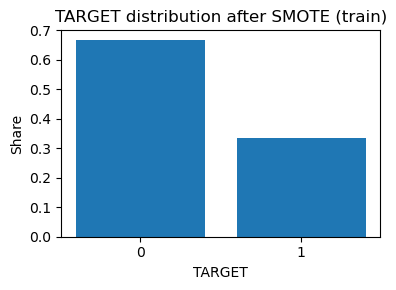

In [44]:
# EDA: TARGET distribution after SMOTE
y = y_tr_res.value_counts(normalize=True).sort_index()
plt.figure(figsize=(4,3))
plt.bar(y.index.astype(int).astype(str), y.values)
plt.xlabel("TARGET")
plt.ylabel("Share")
plt.title("TARGET distribution after SMOTE (train)")
plt.tight_layout()
plt.show()

